### Import libraries

In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from numpy import unique

from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Data preparation

#### Train set

In [ ]:
train_df = pd.read_excel(
    'FNOL_PulFib2022_train.xlsx',
    header=0)
train_df = train_df.drop(columns=["Unnamed: 0", ])

X_train = train_df.drop(columns=["CS_recommended", "ID"])
y_train = train_df["CS_recommended"]
y_train.replace([-1], [0], inplace=True)
train_df


,ID,CS_and_improved,age,BMI,sex,HRCT_interstitial_involvement,HRCT_post - inflammatory_changes,postcovid_disability,CS,CS_during_hospitalization,...,SARS - CoV - 2 IgG(qualit.),SARS - CoV - 2 IgG(quant.),first_dose_before_first_exam,first_dose_type,second_dose_before_first_exam,second_dose_type,third_dose_before_first_exam,third_dose_type,height_(cm),weight_(kg)
0,289,1,64,28.401111,1,1,1,1,1,-1,...,1,277.000000,0,1.0,0,1.0,0,1.0,179.0,91.0
1,153,1,60,24.835646,1,-1,1,1,-1,-1,...,1,162.000000,-1,1.0,-1,1.0,-1,-0.5,185.0,85.0
2,1,1,46,26.753864,-1,-1,1,1,-1,-1,...,1,233.131429,-1,-0.5,-1,-0.5,0,1.0,174.0,81.0
3,1402,1,71,31.645570,-1,-1,-1,1,1,-1,...,1,160.000000,-1,1.0,-1,1.0,0,1.0,158.0,79.0
4,173,1,61,37.341869,-1,-1,1,1,-1,-1,...,1,156.000000,-1,1.0,-1,1.0,-1,1.0,162.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,1388,0,47,23.620288,1,-1,-1,1,1,1,...,1,333.000000,-1,1.0,0,1.0,0,1.0,177.0,74.0
220,945,1,67,30.859607,-1,-1,-1,1,-1,1,...,1,86.300000,-1,-1.0,-1,-1.0,-1,1.0,164.0,83.0
221,145,1,69,30.323343,1,-1,1,1,1,-1,...,1,160.000000,-1,1.0,-1,1.0,0,1.0,177.0,95.0
222,1677,1,59,27.580200,-1,-1,1,1,-1,-1,...,1,193.000000,-1,1.0,-1,1.0,-1,1.0,166.0,76.0


#### Test set

In [ ]:
test_df = pd.read_excel(
    'FNOL_PulFib2022_test.xlsx', header=0)
test_df = test_df.drop(columns=["Unnamed: 0", ])

X_test = test_df.drop(columns=["CS_recommended", "ID"])
y_test = test_df["CS_recommended"]
y_test.replace([-1], [0], inplace=True)
test_df


,ID,CS_and_improved,age,BMI,sex,HRCT_interstitial_involvement,HRCT_post - inflammatory_changes,postcovid_disability,CS,CS_during_hospitalization,...,SARS - CoV - 2 IgG(qualit.),SARS - CoV - 2 IgG(quant.),first_dose_before_first_exam,first_dose_type,second_dose_before_first_exam,second_dose_type,third_dose_before_first_exam,third_dose_type,height_(cm),weight_(kg)
0,1209,0,74,24.419279,1,-1,1,1,-1,-1,...,1,205.000000,-1,-1.0,-1,-1.0,0,1.0,181.000000,80.000000
1,1116,0,60,29.968783,-1,-1,-1,1,-1,-1,...,1,96.500000,-1,1.0,-1,1.0,0,1.0,155.000000,72.000000
2,671,1,81,25.605536,1,-1,-1,1,-1,-1,...,1,128.000000,-1,1.0,-1,1.0,-1,1.0,170.000000,74.000000
3,342,0,54,32.461911,-1,-1,1,2,-1,-1,...,1,95.400000,-1,1.0,0,1.0,0,1.0,152.000000,75.000000
4,1694,0,68,25.880571,1,-1,-1,1,-1,-1,...,1,400.000000,-1,1.0,-1,1.0,0,1.0,178.000000,82.000000
5,245,1,58,30.421850,1,1,1,1,1,-1,...,1,152.000000,-1,1.0,-1,1.0,0,1.0,172.000000,90.000000
6,260,1,75,26.827421,1,1,1,1,1,-1,...,1,400.000000,-1,1.0,-1,1.0,0,1.0,178.000000,85.000000
7,1806,1,47,30.639380,1,-1,-1,1,1,1,...,1,299.000000,0,1.0,0,1.0,0,1.0,186.000000,106.000000
8,919,0,76,27.358845,1,-1,1,1,-1,-1,...,1,400.000000,-1,1.0,-1,1.0,-1,1.0,171.000000,80.000000
9,926,0,74,29.916898,1,-1,-1,1,1,1,...,1,256.000000,-1,-0.5,-1,-0.5,-1,-0.5,190.000000,108.000000


#### All data

In [ ]:
all_data_df = pd.concat([train_df, test_df])

all_data_x = all_data_df.drop(columns=["CS_recommended", "ID"])
all_data_y = all_data_df["CS_recommended"]
all_data_df

,ID,CS_and_improved,age,BMI,sex,HRCT_interstitial_involvement,HRCT_post - inflammatory_changes,postcovid_disability,CS,CS_during_hospitalization,...,SARS - CoV - 2 IgG(qualit.),SARS - CoV - 2 IgG(quant.),first_dose_before_first_exam,first_dose_type,second_dose_before_first_exam,second_dose_type,third_dose_before_first_exam,third_dose_type,height_(cm),weight_(kg)
0,289,1,64,28.401111,1,1,1,1,1,-1,...,1,277.000000,0,1.0,0,1.0,0,1.0,179.0,91.0
1,153,1,60,24.835646,1,-1,1,1,-1,-1,...,1,162.000000,-1,1.0,-1,1.0,-1,-0.5,185.0,85.0
2,1,1,46,26.753864,-1,-1,1,1,-1,-1,...,1,233.131429,-1,-0.5,-1,-0.5,0,1.0,174.0,81.0
3,1402,1,71,31.645570,-1,-1,-1,1,1,-1,...,1,160.000000,-1,1.0,-1,1.0,0,1.0,158.0,79.0
4,173,1,61,37.341869,-1,-1,1,1,-1,-1,...,1,156.000000,-1,1.0,-1,1.0,-1,1.0,162.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,205,0,58,27.160494,1,1,1,1,-1,-1,...,1,218.000000,-1,1.0,-1,1.0,0,1.0,180.0,88.0
53,558,1,76,30.780907,-1,1,1,1,1,1,...,-1,8.610000,-1,1.0,-1,1.0,0,1.0,154.0,73.0
54,1669,1,52,36.592456,1,-1,-1,1,1,1,...,1,260.000000,-1,1.0,-1,1.0,0,1.0,171.0,107.0
55,1469,0,63,29.263340,1,-1,-1,1,1,1,...,1,164.000000,1,1.0,-1,1.0,-1,1.0,183.0,98.0


#### Train distribution

CS_and_improved
0    116
1    108
dtype: int64


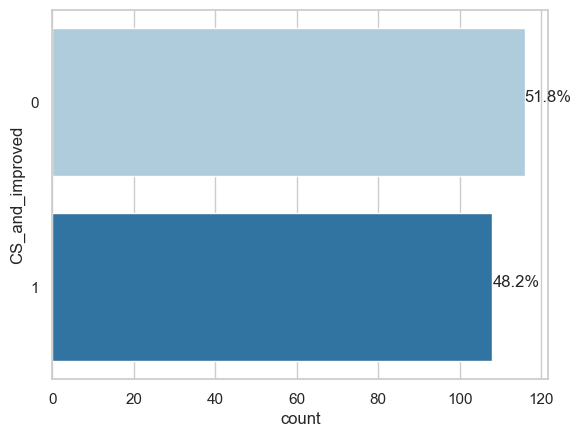

In [ ]:
sns.set_theme(style="whitegrid")

ax = sns.countplot(y="CS_recommended", data=train_df, alpha=1, palette="Paired")
total = train_df.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

print(train_df.groupby('CS_recommended').size())
plt.show()


#### Test distribution

CS_and_improved
0    30
1    27
dtype: int64


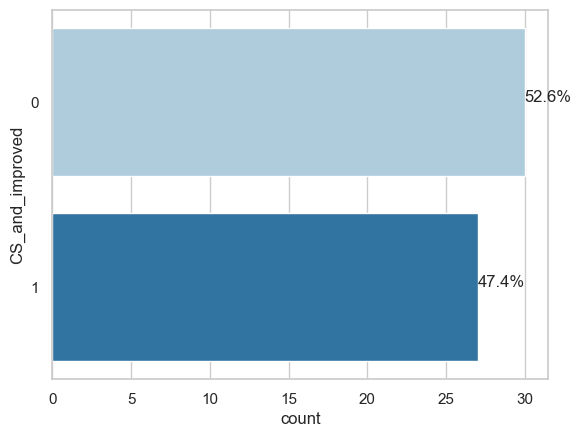

In [ ]:
ax = sns.countplot(y="CS_recommended", data=test_df, alpha=1, palette="Paired")
total = test_df.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

print(test_df.groupby('CS_recommended').size())
plt.show()

## Feature selection

#### Shap

0.5789473684210527


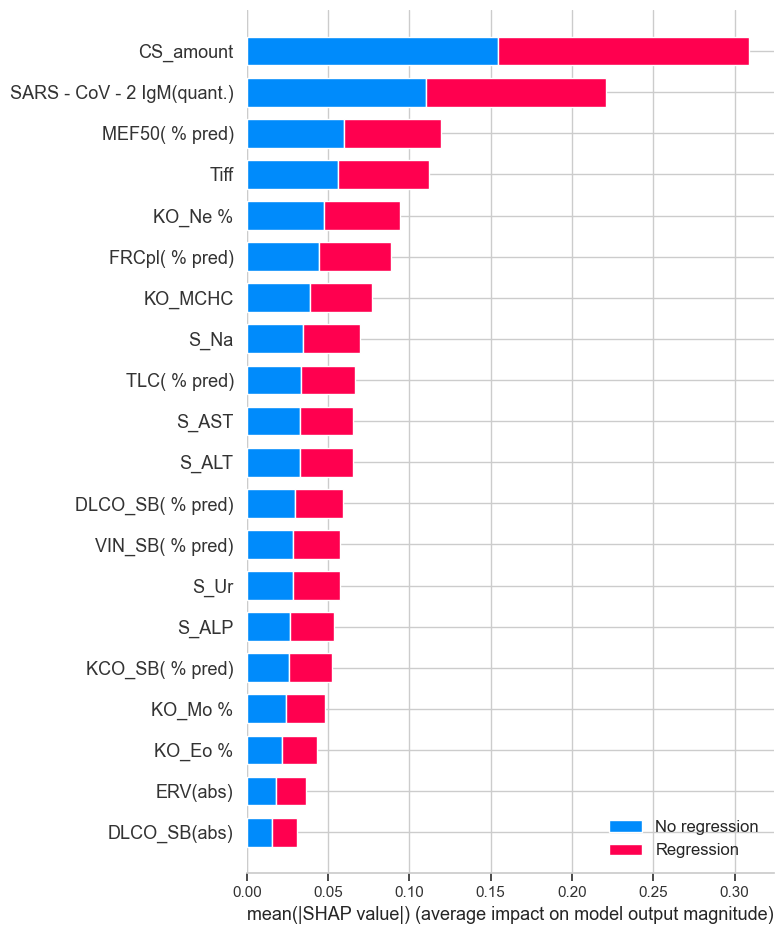

In [ ]:
reg = DecisionTreeClassifier(random_state=2)
reg.fit(X_train, y_train)

r2_score = reg.score(X_test, y_test)
print(r2_score)

shap_values = shap.TreeExplainer(reg, ).shap_values(X_test)
shap.summary_plot(shap_values, X_train, class_names=['No regression', 'Regression'], show=False)


#### K best

In [ ]:
fs = SelectKBest(k=25)
fs.fit(all_data_x, all_data_y)

mask = fs.get_support()
new_features = all_data_x.columns[mask]

new_features

Index(['HRCT_interstitial_involvement', 'CS', 'CS_amount', 'CS_duration_weeks',
       'CS_total', 'hospitalized', 'remdesivir', 'olfactory_loss',
       'comorbidity', 'VC(abs)', 'FEV1(abs)', 'FVC(abs)', 'PEF(abs)',
       'PEF( % pred)', 'MEF75(abs)', 'MEF75( % pred)', 'ERV(abs)',
       'VA_SB(abs)', 'VA_SB( % pred)', 'VIN_SB(abs)', 'KO_Leu', 'KO_MCHC',
       'KO_RDW', 'KO_Mo %', 'SARS - CoV - 2 IgM(quant.)'],
      dtype='object')

#### Select features

In [ ]:
select_feature = unique(['pneumonia', 'CS_another_problems', 'CS', 'olfactory_loss', 'postcovid_disability',
                         'SARS - CoV - 2 IgG(qualit.)', 'SARS - CoV - 2 IgM(quant.)', 'CS_amount', 'CS_total',
                         'CS_duration_weeks', 'KO_RDW', 'VC(abs)', 'FVC( % pred)', 'FEV1(abs)', 'KO_Mo %',
                         'PEF( % pred)', 'DLCOc_SB(abs)', 'KCO_SB(abs)', 'persistent_cough', 'persistent_dyspnea',
                         'MEF25(abs)',
                         ])

x_train_filtered = X_train[select_feature]
x_test_filtered = X_test[select_feature]

## Train and test (Manual)

In [ ]:
def get_scores(report_df, model, X_test, y_test, name):
    report = pd.DataFrame(data={
        'Accuracy': [model.score(X_test, y_test)],
        'Balanced accuracy': [balanced_accuracy_score(y_test, model.predict(X_test))],
        'ROC-AUC': [roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])],
        'F1': [f1_score(y_test, model.predict(X_test))],
        'Precision': [precision_score(y_test, model.predict(X_test), average="binary")],
        'Recall': [recall_score(y_test, model.predict(X_test), average="binary")]
    })

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [ ]:
df_report = pd.DataFrame()
results_dict = {}

LogisticRegression
0.6140350877192983
MLPClassifier
0.7017543859649122
DecisionTreeClassifier
0.631578947368421
RandomForestClassifier
0.7017543859649122
KNeighborsClassifier
0.6842105263157895
SVC
0.631578947368421
AdaBoostClassifier
0.7017543859649122
XGBClassifier
0.6140350877192983
LGBMClassifier
0.631578947368421


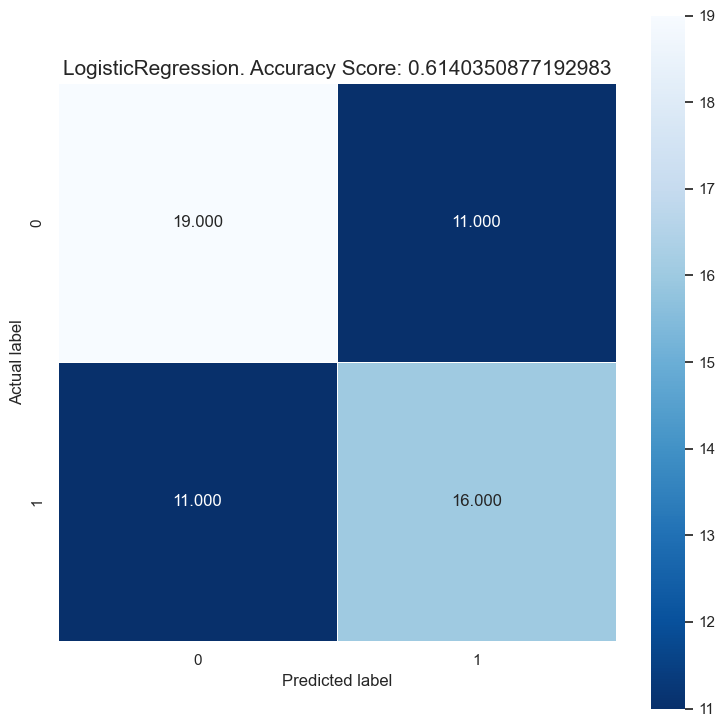

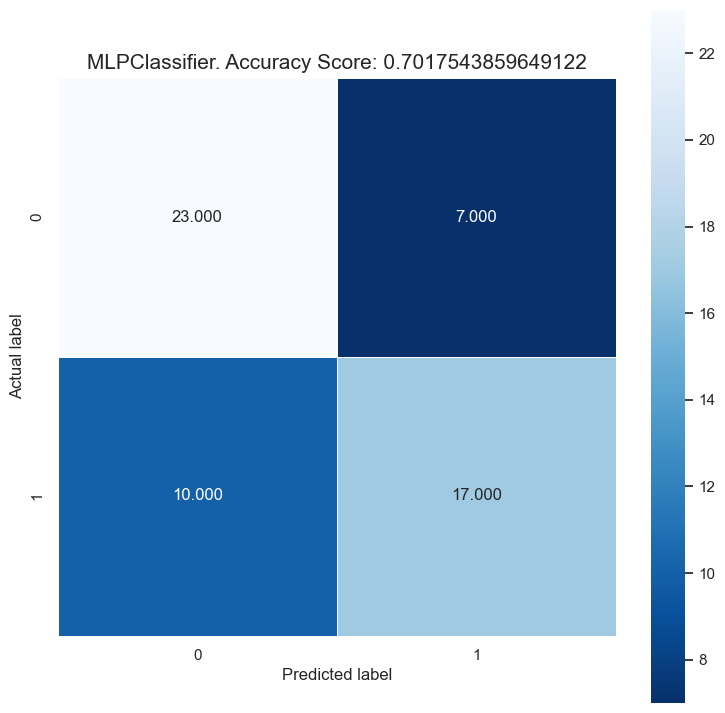

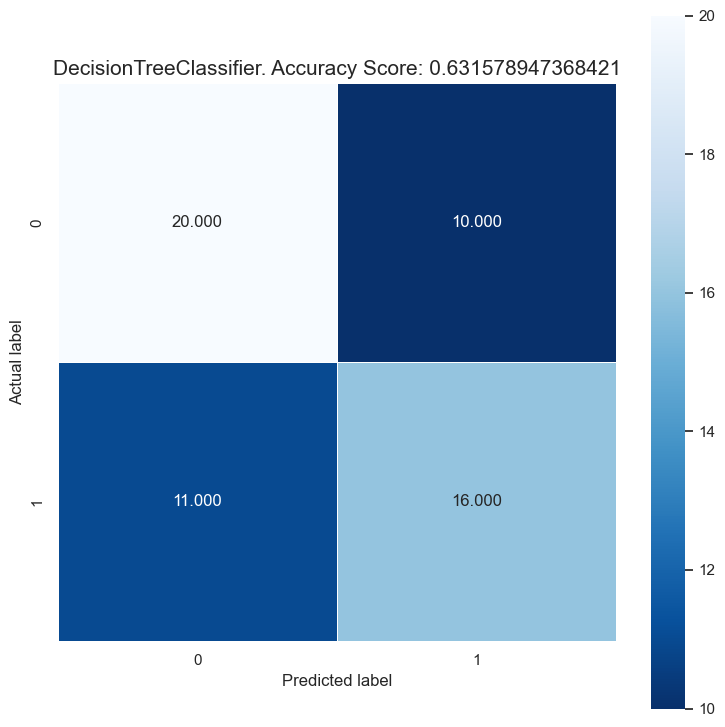

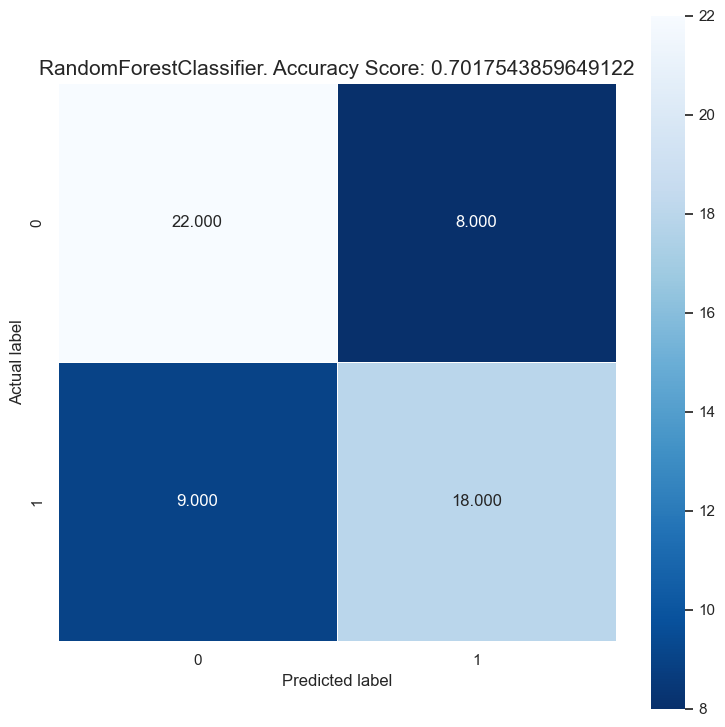

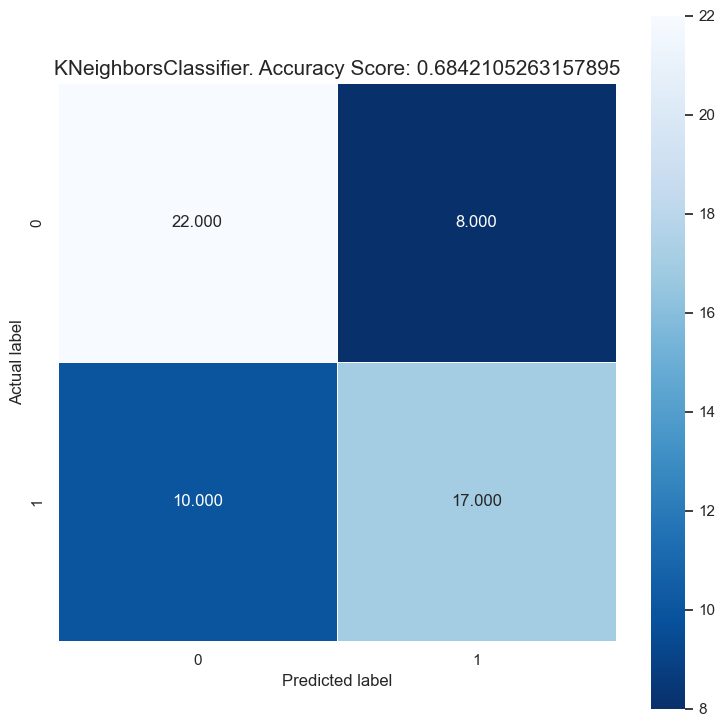

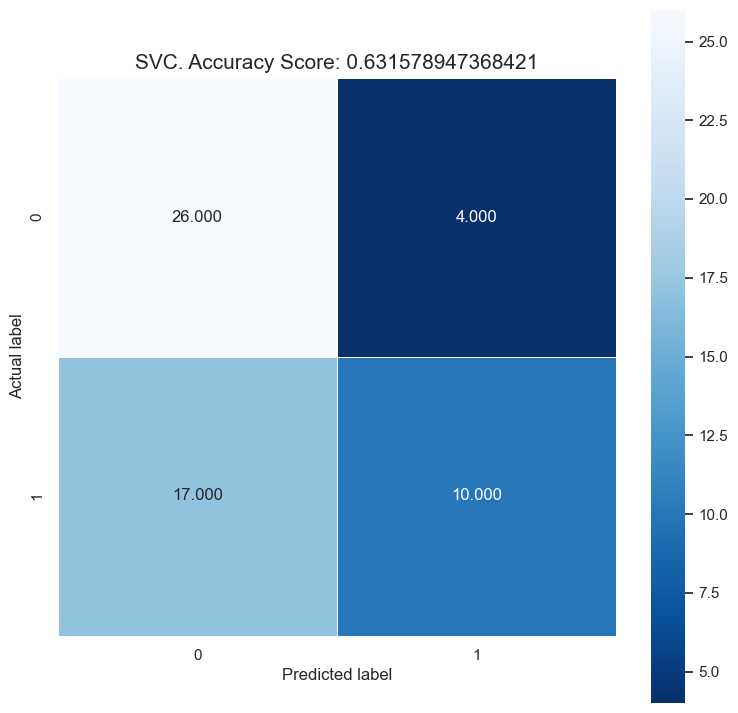

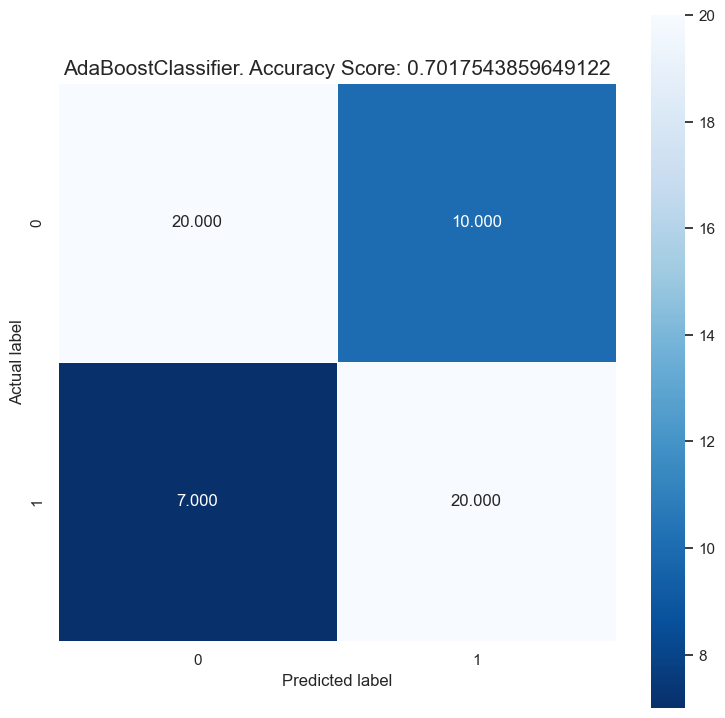

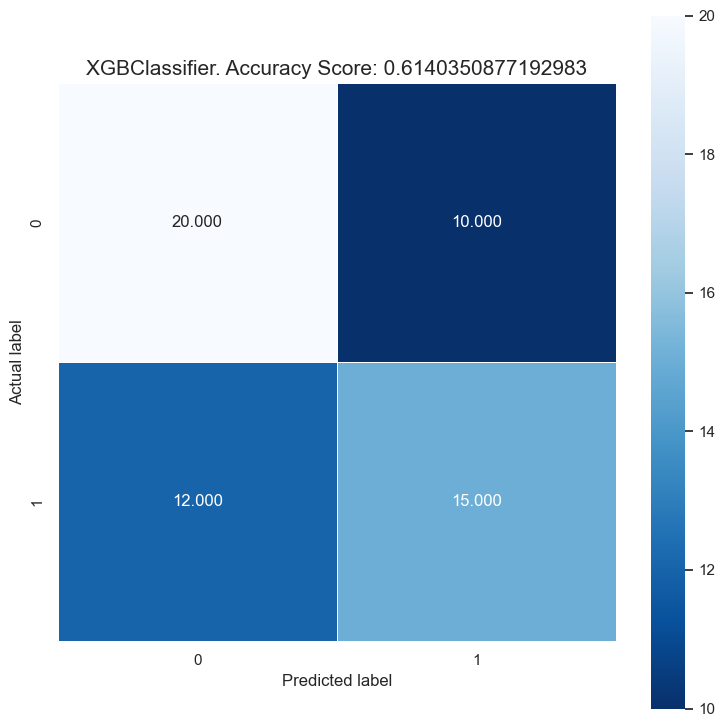

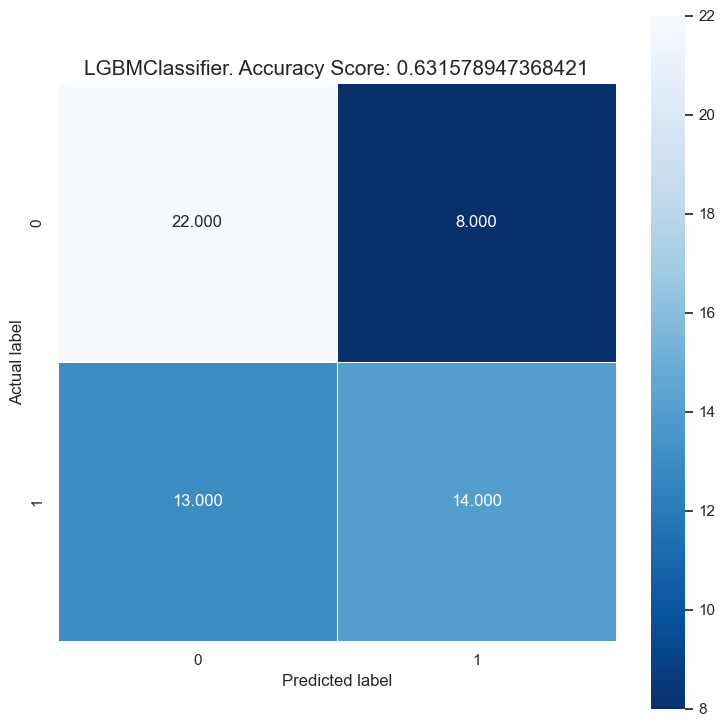

In [ ]:
alg_lr = LogisticRegression(class_weight='balanced')
alg_DT = DecisionTreeClassifier(random_state=2022, max_depth=6, min_samples_leaf=8, max_features='auto')
alg_RF = RandomForestClassifier(criterion='entropy', random_state=2022, max_depth=6)
alg_MLP = MLPClassifier(hidden_layer_sizes=(70, 8), solver='adam', random_state=42, max_iter=80, activation="relu")
alg_KN = KNeighborsClassifier(weights='distance', n_neighbors=5)
alg_SVC = SVC(random_state=42, C=3, probability=True, class_weight='balanced', kernel="sigmoid")
alg_adaboost = AdaBoostClassifier(n_estimators=12, random_state=42, learning_rate=0.8)
alg_xgboost = XGBClassifier(max_depth=10, eval_metric='logloss', seed=4)

alg_lgbm = LGBMClassifier(class_weight='balanced', learning_rate=0.5, max_depth=3)

alg_list = [alg_lr, alg_MLP, alg_DT, alg_RF, alg_KN, alg_SVC, alg_adaboost, alg_xgboost, alg_lgbm]

for reg in alg_list:
    #Train and test
    reg.fit(x_train_filtered, y_train)
    score = reg.score(x_test_filtered, y_test)
    print(type(reg).__name__)
    print(score)
    predicts = reg.predict(x_test_filtered)
    cm = confusion_matrix(y_test, predicts)

    #Plot confusion matrix
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = '{0}. Accuracy Score: {1}'.format(type(reg).__name__, score)
    plt.title(all_sample_title, size=15)

    #Add to report
    df_report = get_scores(df_report, reg, x_test_filtered,
                           y_test, type(reg).__name__)

In [ ]:
df_report

,Accuracy,Balanced accuracy,ROC-AUC,F1,Precision,Recall
LogisticRegression,0.614035,0.612963,0.634568,0.592593,0.592593,0.592593
MLPClassifier,0.701754,0.698148,0.720988,0.666667,0.708333,0.629630
DecisionTreeClassifier,0.631579,0.629630,0.654938,0.603774,0.615385,0.592593
RandomForestClassifier,0.701754,0.700000,0.706173,0.679245,0.692308,0.666667
KNeighborsClassifier,0.684211,0.681481,0.662963,0.653846,0.680000,0.629630
SVC,0.631579,0.618519,0.703704,0.487805,0.714286,0.370370
AdaBoostClassifier,0.701754,0.703704,0.635802,0.701754,0.666667,0.740741
XGBClassifier,0.614035,0.611111,0.662963,0.576923,0.600000,0.555556
LGBMClassifier,0.631579,0.625926,0.691358,0.571429,0.636364,0.518519


### Train and test (with RandomizedSearchCV)

In [ ]:
df_report_2 = pd.DataFrame()
num_iteration = 150
cv_inner = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
def xval_test(model, space, df_report, draw_dt=False):
    acc_best = 0
    yhat = 0
    params_best = dict()

    for i in range(0, num_iteration):
        search = RandomizedSearchCV(model, space, scoring='roc_auc', random_state=42, cv=cv_inner, refit=True)
        result = search.fit(x_train_filtered, y_train)
        best_model = result.best_estimator_
        yhat_temp = best_model.predict(x_test_filtered)
        acc = accuracy_score(y_test, yhat_temp)
        if acc_best < acc:
            best_model_save = best_model
            params_best = result.best_params_
            acc_best = acc
            yhat = yhat_temp

    print(type(best_model_save).__name__)
    print('>acc=%.3f, cfg=%s' % (acc_best, params_best))
    print('Accuracy: %.3f ' % acc_best)
    cm = confusion_matrix(y_test, yhat, normalize='all')

    #Plot confusion matrix
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('{0}. Accuracy Score: {1}'.format(type(best_model_save).__name__, acc_best), size=15)

    # Reports
    df_report = get_scores(df_report, best_model_save, x_test_filtered,
                           y_test, type(best_model_save).__name__)

    if draw_dt:
        fig = plt.figure(figsize=(25, 20))
        _ = tree.plot_tree(best_model_save,
                           feature_names=select_feature,
                           class_names=['0', '1'],
                           filled=True)
        fig.savefig("decision_tree.svg", format='svg', dpi=1200)

    return df_report

In [ ]:
alg_RF = RandomForestClassifier(random_state=2022)
alg_lr = LogisticRegression(class_weight='balanced')
alg_DT = DecisionTreeClassifier(random_state=2022)
alg_MLP = MLPClassifier(random_state=42)
alg_KN = KNeighborsClassifier()
alg_SVC = SVC(random_state=42, probability=True, class_weight='balanced')
alg_adboost = AdaBoostClassifier(random_state=42)
alg_xgboost = XGBClassifier(eval_metric='logloss')
alg_lgbm = LGBMClassifier(class_weight='balanced')

space_rf = {
    "n_estimators": [i for i in range(1, 60, 3)],
    "max_features": [i for i in range(1, 15)],
    "max_depth": [i for i in range(2, 10)],
    "criterion": ["gini", "entropy"]
}

space_lr = {
    "C": np.linspace(0, 10, 100),
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

space_dt = {
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [i for i in range(2, 15)],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [i for i in range(1, 20)],
}

space_mlp = {
    "solver": ['lbfgs', 'sgd', 'adam'],
    "hidden_layer_sizes": [i for i in range(2, 200)],
    "max_iter": [i for i in range(2, 150)],
}

space_kn = {
    "n_neighbors": [i for i in range(2, 30)],
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

space_svc = {
    "C": np.linspace(0, 10, 100),
    "kernel": ['poly', 'rbf']
}

space_adboost = {
    "learning_rate": np.linspace(0, 1, 10),
    "n_estimators": [i for i in range(1, 30)]
}

space_xgboost = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

space_lgbm = {'learning_rate': [0.005, 0.1],
              'num_leaves': [i for i in range(1, 20)],
              }



RandomForestClassifier
>acc=0.579, cfg={'n_estimators': 19, 'max_features': 10, 'max_depth': 3, 'criterion': 'gini'}
Accuracy: 0.579 
LogisticRegression
>acc=0.544, cfg={'solver': 'sag', 'C': 1.4141414141414141}
Accuracy: 0.544 
DecisionTreeClassifier
>acc=0.737, cfg={'min_samples_leaf': 13, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'entropy'}
Accuracy: 0.737 
MLPClassifier
>acc=0.632, cfg={'solver': 'sgd', 'max_iter': 18, 'hidden_layer_sizes': 16}
Accuracy: 0.632 
KNeighborsClassifier
>acc=0.649, cfg={'weights': 'distance', 'n_neighbors': 10, 'algorithm': 'brute'}
Accuracy: 0.649 
SVC
>acc=0.579, cfg={'kernel': 'rbf', 'C': 5.757575757575758}
Accuracy: 0.579 
AdaBoostClassifier
>acc=0.632, cfg={'n_estimators': 28, 'learning_rate': 0.4444444444444444}
Accuracy: 0.632 
XGBClassifier
>acc=0.579, cfg={'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 0, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 0.5}
Accuracy: 0.579 
LGBMClassifier
>acc=0.579,

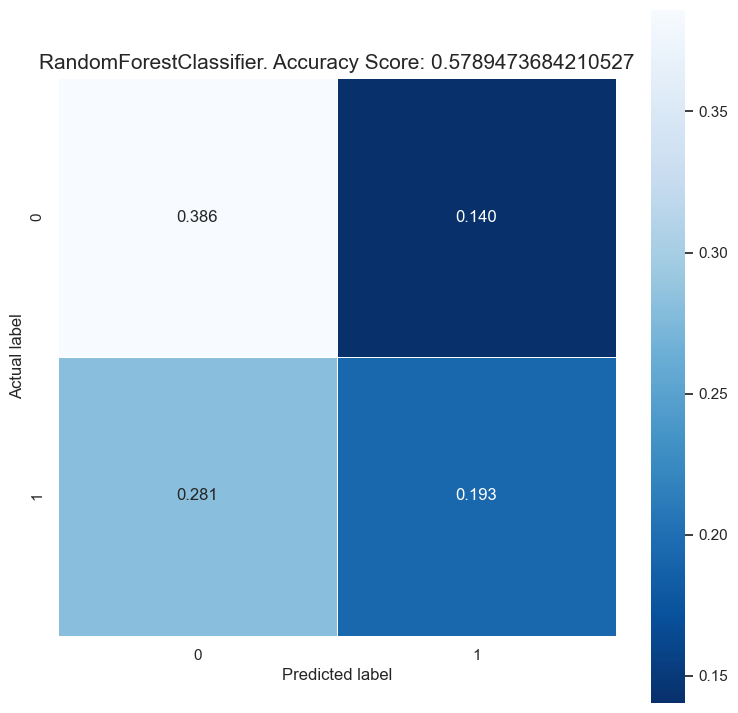

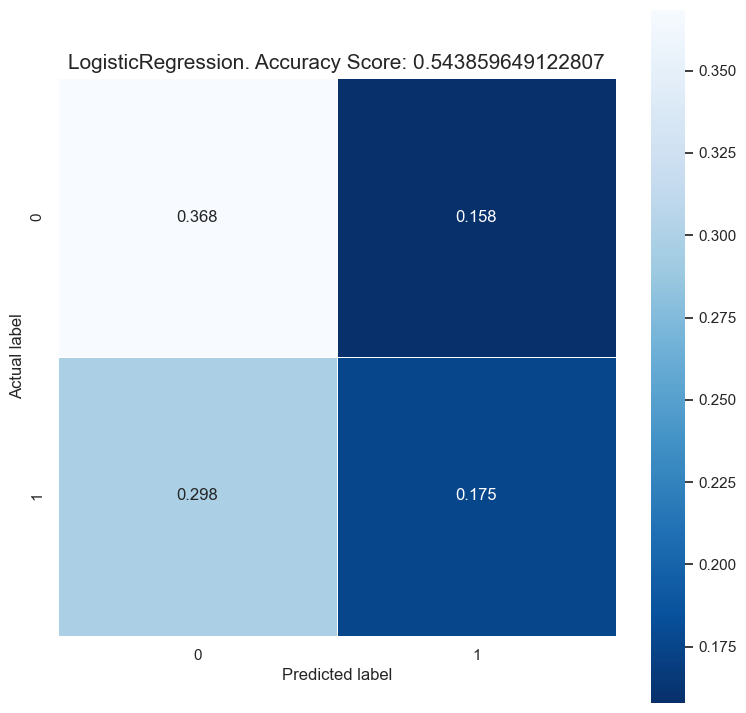

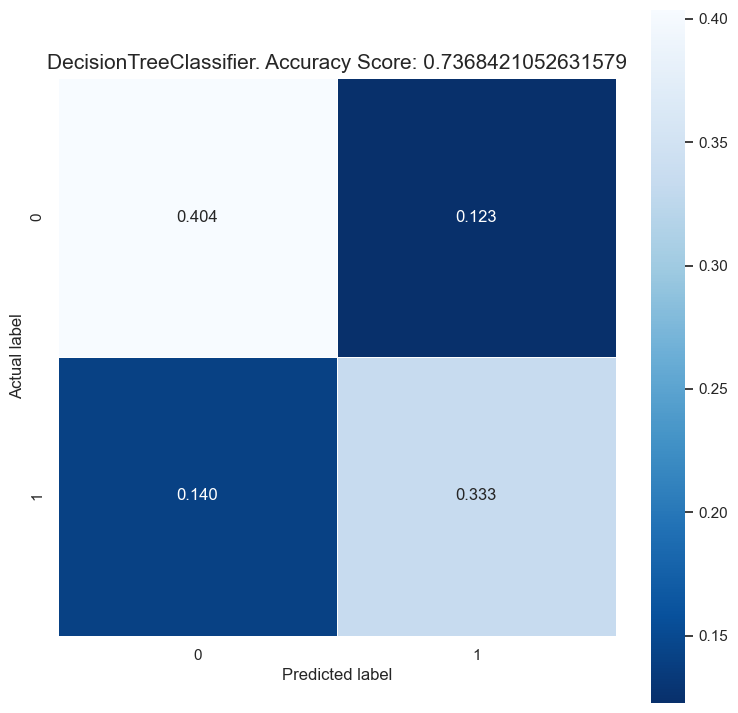

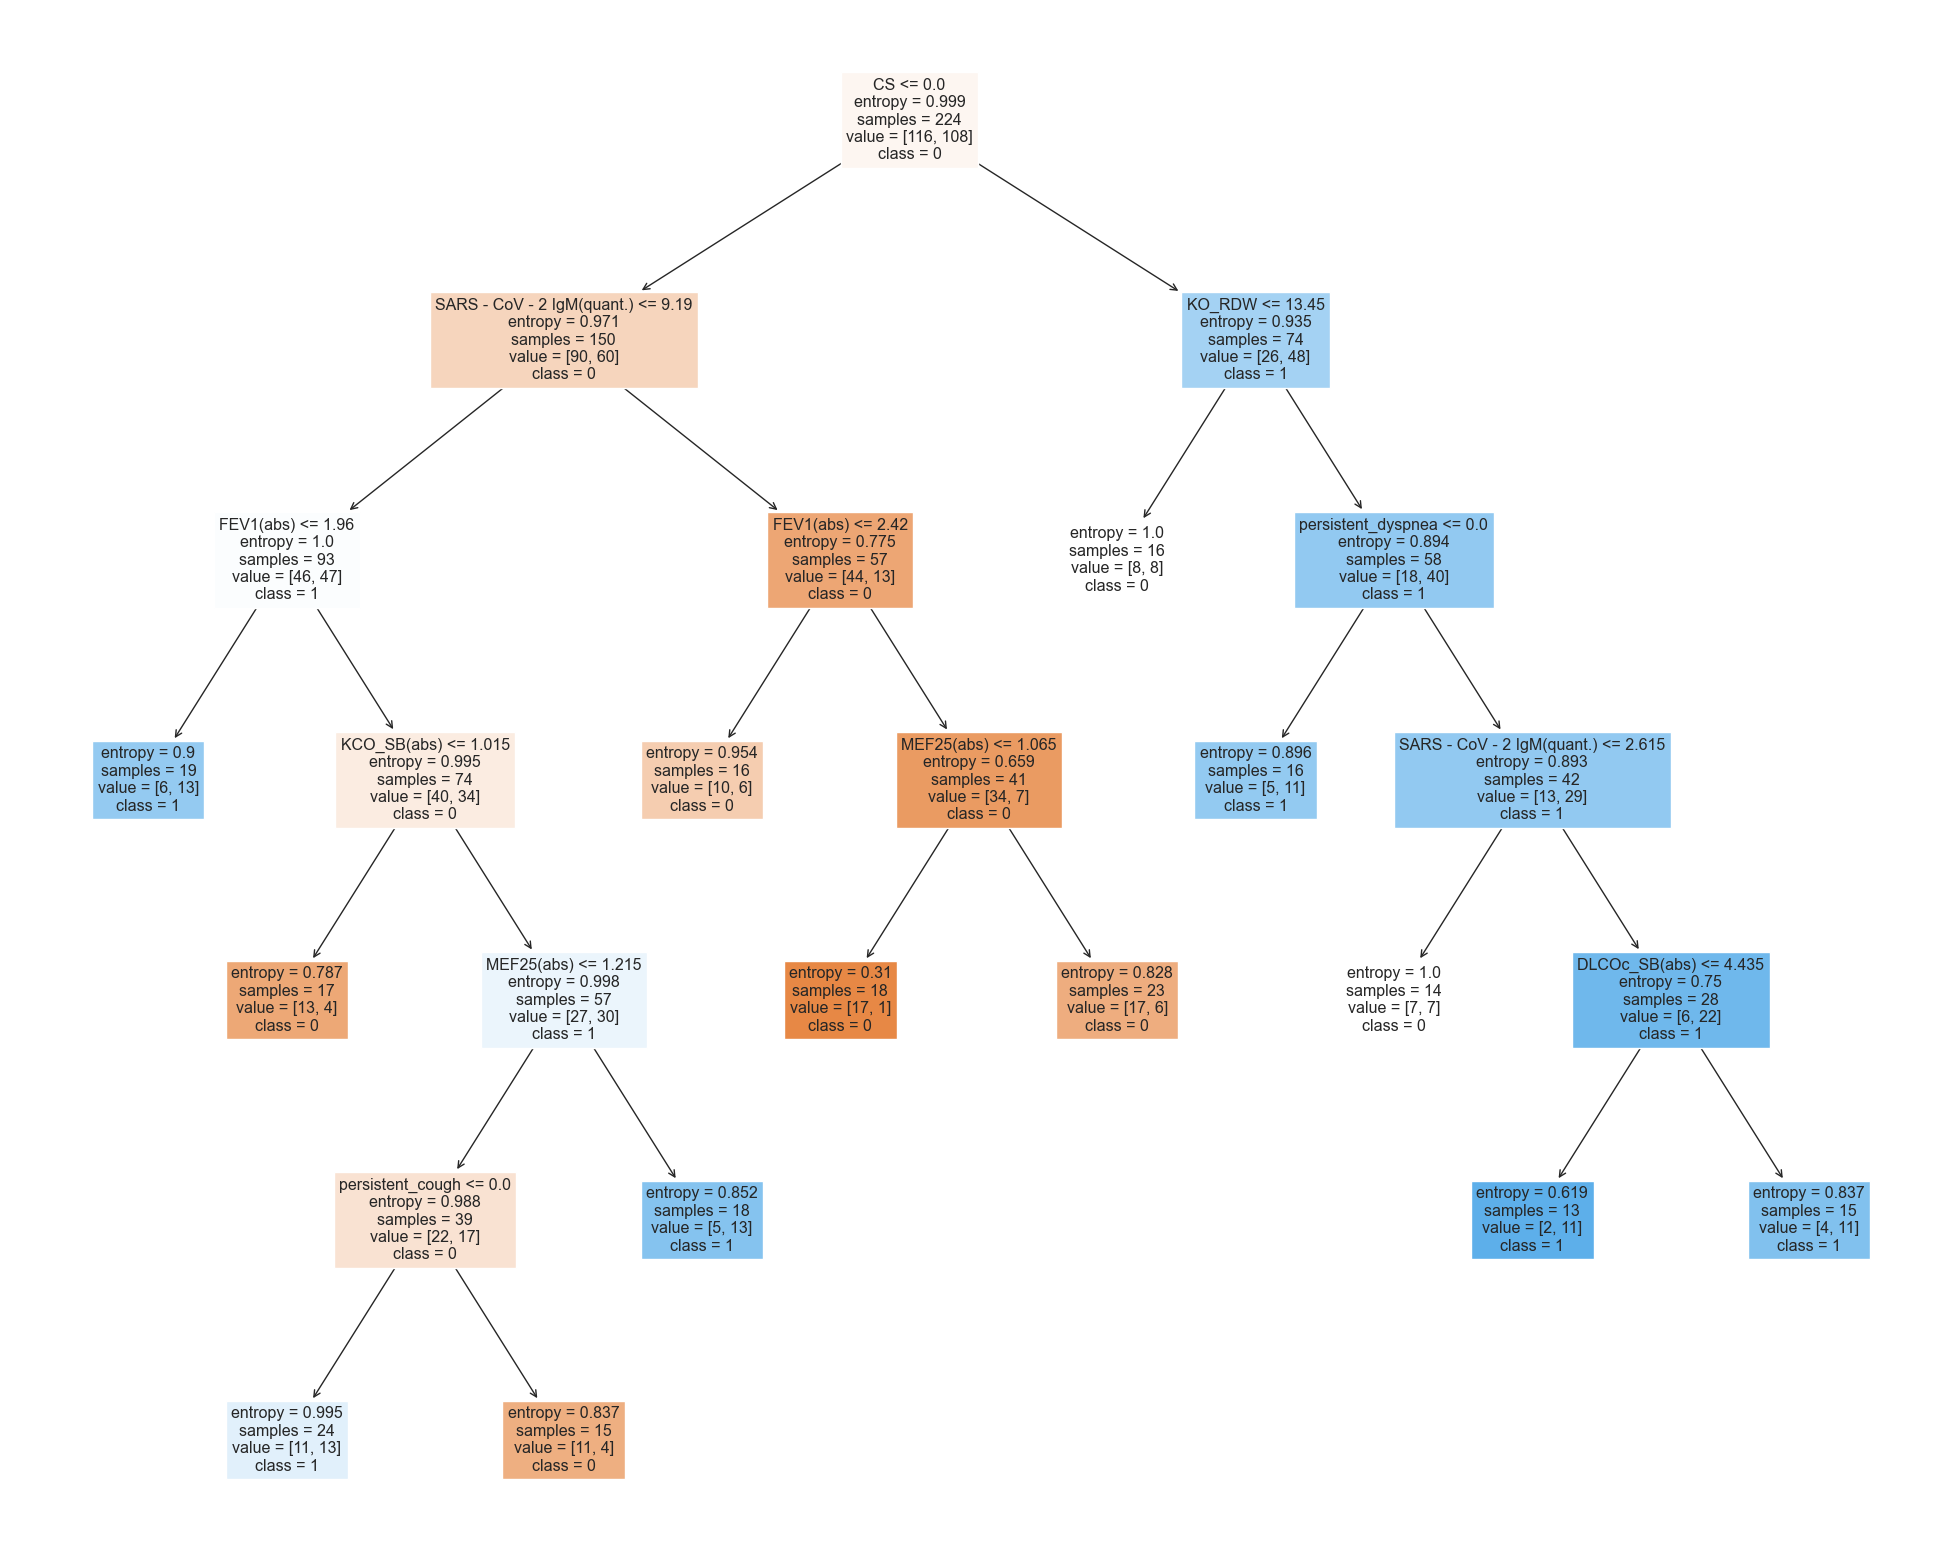

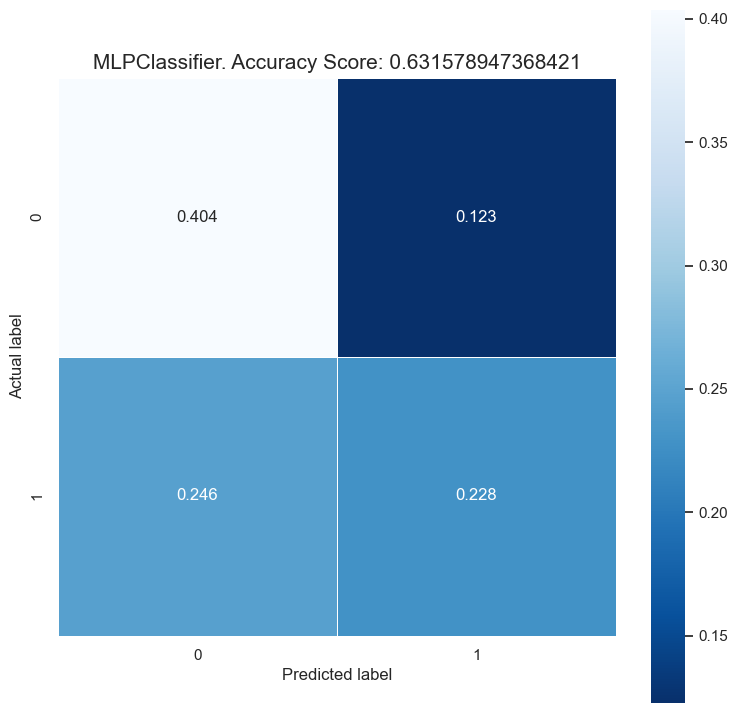

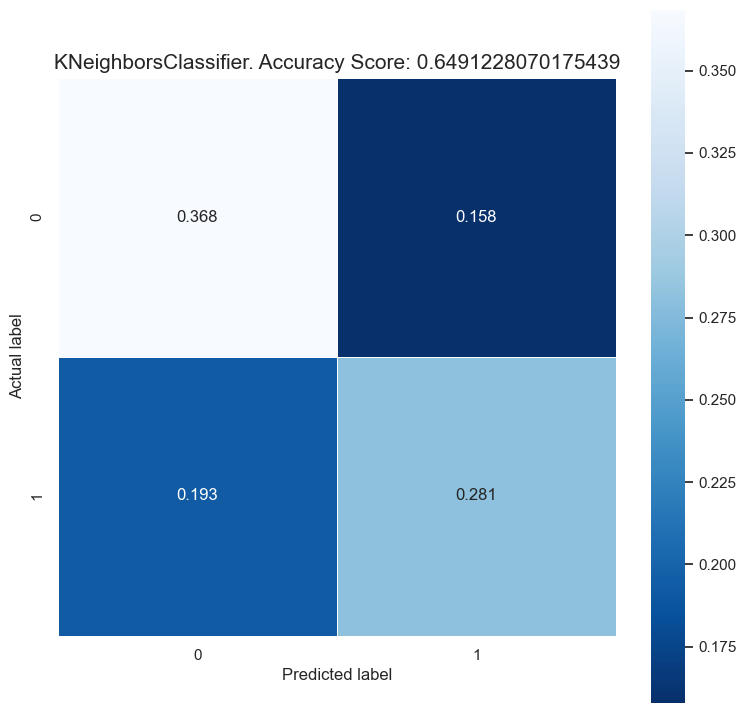

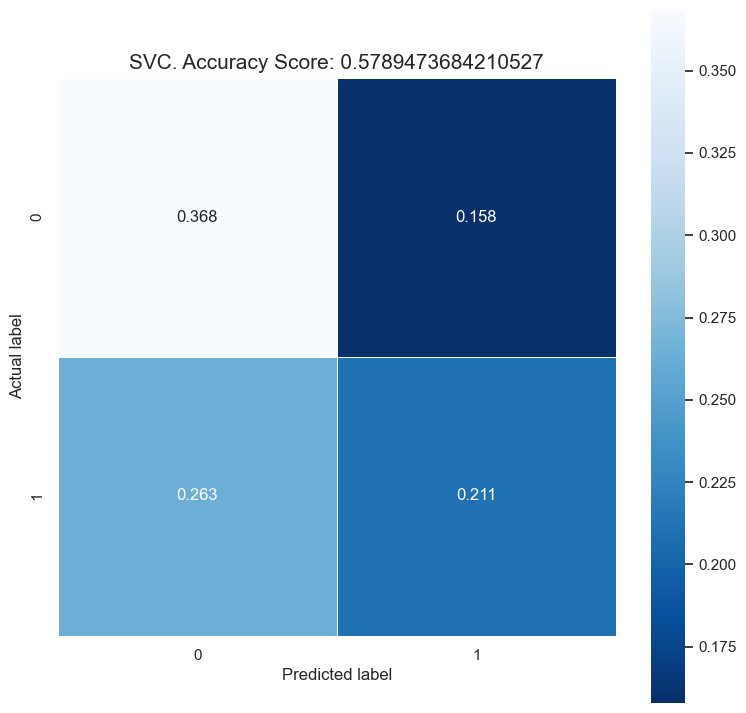

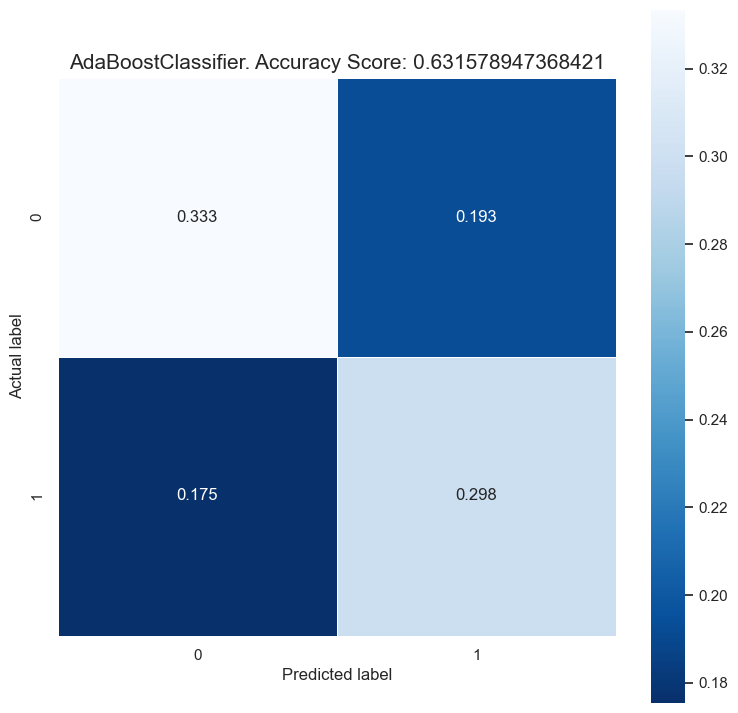

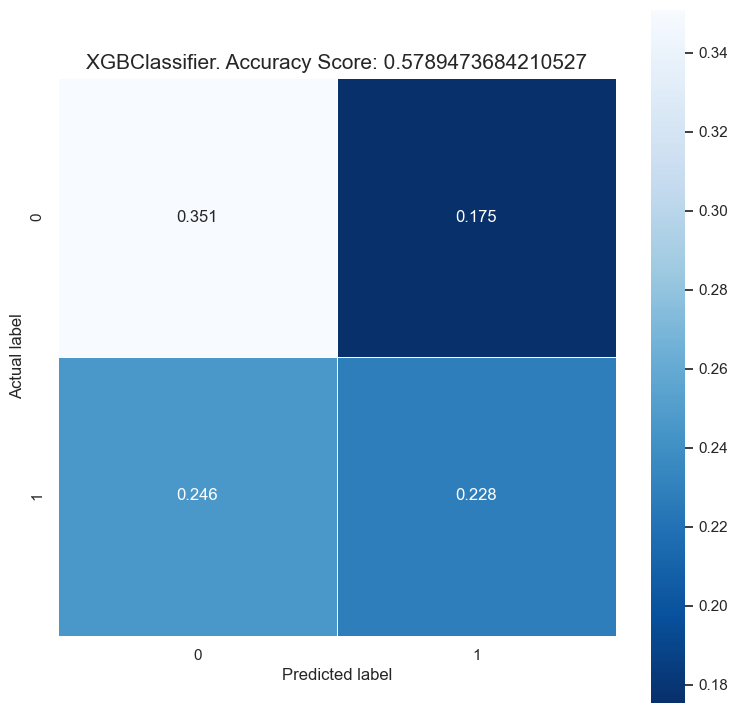

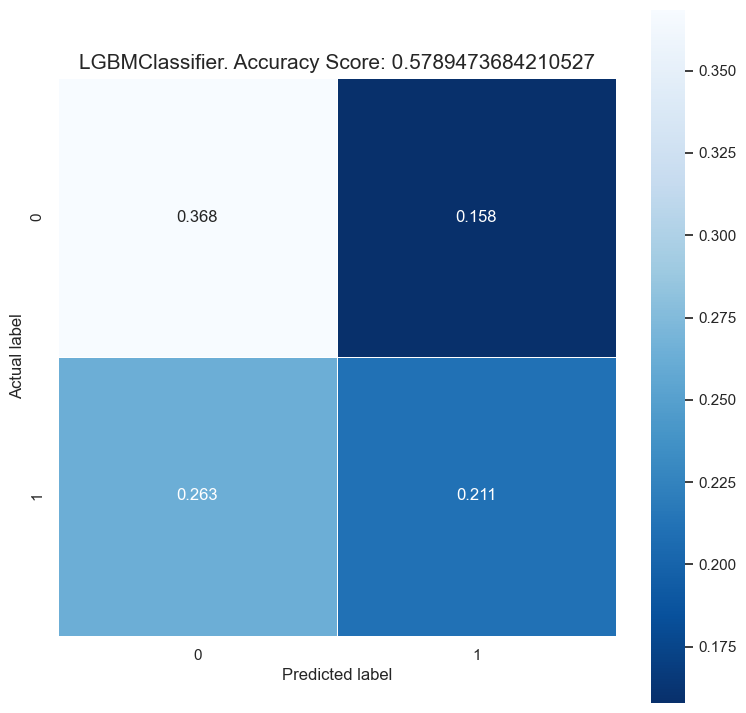

In [ ]:
df_report_2 = xval_test(alg_RF, space_rf, df_report_2)
df_report_2 = xval_test(alg_lr, space_lr, df_report_2)
df_report_2 = xval_test(alg_DT, space_dt, df_report_2, True)
df_report_2 = xval_test(alg_MLP, space_mlp, df_report_2)
df_report_2 = xval_test(alg_KN, space_kn, df_report_2)
df_report_2 = xval_test(alg_SVC, space_svc, df_report_2)
df_report_2 = xval_test(alg_adboost, space_adboost, df_report_2)
df_report_2 = xval_test(alg_xgboost, space_xgboost, df_report_2)
df_report_2 = xval_test(alg_lgbm, space_lgbm, df_report_2)

In [ ]:
df_report_2

,Accuracy,Balanced accuracy,ROC-AUC,F1,Precision,Recall
RandomForestClassifier,0.578947,0.570370,0.639506,0.478261,0.578947,0.407407
LogisticRegression,0.543860,0.535185,0.625926,0.434783,0.526316,0.370370
DecisionTreeClassifier,0.736842,0.735185,0.746914,0.716981,0.730769,0.703704
MLPClassifier,0.631579,0.624074,0.728395,0.553191,0.650000,0.481481
KNeighborsClassifier,0.649123,0.646296,0.674074,0.615385,0.640000,0.592593
SVC,0.578947,0.572222,0.677778,0.500000,0.571429,0.444444
AdaBoostClassifier,0.631579,0.631481,0.654321,0.618182,0.607143,0.629630
XGBClassifier,0.578947,0.574074,0.653086,0.520000,0.565217,0.481481
LGBMClassifier,0.578947,0.572222,0.651852,0.500000,0.571429,0.444444
